# Manejo de Datos Faltantes: Imputación

## Indice <a id='indice'></a>

0. [Configuración previa](#tema0)
1. [El problema de trabajar con valores faltantes](#tema1)
2. [Proceso de análisis y limpieza de datos](#tema2)
3. [Visualizar y eliminar valores faltantes](#tema3)
4. [Implicaciones de los distintos tipos de valores faltantes](#tema4)
5. [Amplia tu conjunto de herramientas para explorar valores faltantes](#tema5)
6. [Tratamiento de variables categóricas para imputación: codificación ordinal](#tema6)
7. [Tratamiento de variables categóricas para imputación: one-hot encoding](#tema7)
8. [Métodos de imputación de valores faltantes](#tema8)
9. [Imputación por media, mediana y moda](#tema9)
10. [Imputación por llenado hacia atrás y hacia adelante](#tema10)
11. [Imputación por interpolación](#tema11)
12. [Imputación por KNN](#tema12)
13. [Imputación por KNN en Python](#tema13)
14. [Introducción a la imputación basada en modelos](#tema14)
15. [Imputaciones Múltiples por Ecuaciones Encadenadas(MICE)](#tema15)
16. [Transformación inversa de los datos](#tema16)
17. [¿Cómo continuar practicando?](#tema17)


## Configuración de ambiente de trabajo <a id='tema0'></a>  

[Ir a indice](#indice)

Primero creemos un entorno con conda y después ejecutemos el archivo [requirements.txt](requirements.txt) para instalar las dependencias adecuadas.

```sh
#Crear un entorno llamado detección con python 3.9
conda create --name imputacion python=3.9
#Para que sea más rápido lo haré con mamba
mamba create --name imputacion python=3.9
#activar el entorno
conda activate imputacion
#instalar las dependencias desde requirements.txt
mamba install --file requirements.txt
#crear archivo requirements.txt si no lo tengo
mamba env export > requirements.txt
```

Si no podemos instalar con Conda, podemos usar este código:
```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

### Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/nhanes/load.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


### Importar funciones personalizadas

In [2]:
#Instala antes nbformat
%run pandas-missing-extension-re.ipynb

La función anterior proviene del curso anterior.

## El problema de trabajar con valores faltantes <a id='tema1'></a>

[Ir a indice](#indice)

Esto lo abarcamos en el anterior curso de Exploración y detección de valores faltantes.

Problemas que nos podemos encontrar:
1. Ignorar valores faltantes: Introduce **sesgos** en el análisis y modelos. De tal manera que *Sobreestimamos o Subestimamos* al valor real, provoca problemas serios al momento de reportar los resultados.
2. Multiples algoritmos fallarán: Los algoritmos que tenemos disponibles en la red, fallarán; es decir aparecerán errores y otros estarán dando resultados no deseados.

Nosotros hablamos anteriormente sobre la imputación, pero nunca la definimos.

### Imputación

Estimar los valores ausentes con base en los valores válidos de otras variables y/o casos de muestra.

A continuación vamos a proceder a empezar a trabajar:

In [3]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year",1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year","month","day"]])    
    )
    .sort_values(by='date')
    .set_index('date')
)
airquality_df

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


En el código anterior lo que hicimos fue traer un data set de R, y añadimos una columna con formato de fecha.

Ademas el conjunto de datos lo usaremos en clases posteriores.

### ¿Cuál es el problema?
Imaginemos que ya tenemos los datos y queremos ajustarlos a un modelo, entonces procedemos a realizar lo siguiente:

In [4]:
(
    smf.ols(
        formula="temp ~ ozone",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Tue, 03 Dec 2024",Prob (F-statistic):,2.93e-18
Time:,00:59:28,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


De momento ya tenemos las variables dependientes y el modelo que utilizamos, es decir parece que está bien.

Pero recordemos que algunas variables tienen valores faltantes.

¿Qué pasaría si yo quiero considerar otra variable?

*solar_r*

In [5]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Tue, 03 Dec 2024",Prob (F-statistic):,1.47e-16
Time:,00:59:28,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


Todo bien al parecer, no nos da ningún error.

**Pero ese es el problema precisamente de los valores faltantes; es decir no nos arrojan errores**

Pero si existe.

Veamos el número de observaciones en nuestro modelo;
 - Modelo: 116 observaciones
 - Data Frame: 153 observaciones

Entonces cuando creamos el primer modelo **tenemos 116 observaciones**. Y si creamos el segundo, vemos que disminuye a **111 observaciones.**

Es decir también perdimos más filas, y a pesar que queramos comparar los modelos, como normalmente lo haríamos con el $R^2$ no podríamos hacerlo, porque ambos modelos están siendo ajustados a partir de diferentes conjuntos de datos y eso hace que se pierda información. Debido a que los algoritmos descartan ciertos valores, así que cuando nosotros tenemos valores faltantes no es recomendable hacer esto.

Esto es un problema porque puede parecer que es adecuado, ya que no nos arroja ningún *Warning* o *Error*- Por ello, siempre hay que estar atento.

Por eso, en este curso nos enfocaremos en la imputación de valores faltantes:

### Reto: Datos de supervivientes

In [6]:
survival_df = sm.datasets.get_rdataset("flchain","survival").data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [7]:
survival_df.columns

Index(['age', 'sex', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine',
       'mgus', 'futime', 'death', 'chapter'],
      dtype='object')

In [8]:
(
    smf.ols(
        formula="death ~ chapter",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-143.5
Date:,"Tue, 03 Dec 2024",Prob (F-statistic):,1.00
Time:,00:59:29,Log-Likelihood:,71215.
No. Observations:,2169,AIC:,-1.424e+05
Df Residuals:,2153,BIC:,-1.423e+05
Df Model:,15,,
Covariance Type:,nonrobust,,


In [9]:
(
    smf.ols(
        formula="death ~ age + chapter",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-134.5
Date:,"Tue, 03 Dec 2024",Prob (F-statistic):,1.00
Time:,00:59:29,Log-Likelihood:,69860.
No. Observations:,2169,AIC:,-1.397e+05
Df Residuals:,2152,BIC:,-1.396e+05
Df Model:,16,,
Covariance Type:,nonrobust,,


## Proceso de análisis y limpieza de datos <a id='tema2'></a>

[Ir a Indice](#indice)

En este curso conoceremos, exploraremos y limpiaremos nuestro set de datos antes de imputarlos.

En este caso examinaremos NHANES.

### Preparando datos: _National Health and Nutrition Examination Survey_

In [10]:
(
    nhanes.load.load_NHANES_data(year="2017-2018")
)

,GeneralHealthCondition,EverBreastfedOrFedBreastmilk,AgeStoppedBreastfeedingdays,AgeFirstFedFormuladays,AgeStoppedReceivingFormuladays,AgeStartedOtherFoodbeverage,AgeFirstFedMilkdays,TypeOfMilkFirstFedWholeMilk,TypeOfMilkFirstFed2Milk,TypeOfMilkFirstFed1Milk,...,DaysSmokedCigsDuringPast30Days,AvgCigarettesdayDuringPast30Days,TriedToQuitSmoking,TimesStoppedSmokingCigarettes,HowLongWereYouAbleToStopSmoking,UnitOfMeasureDayweekmonthyear_2_SMQ,CurrentSelfreportedHeightInches,CurrentSelfreportedWeightPounds,TriedToLoseWeightInPastYear,TimesLost10LbsOrMoreToLoseWeight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


Como se puede observar tenemos un total de:
- 8366 filas 
- 197 columnas

También podemos ver que podemos cambiar el encabezado de las columnas a un tipo diferente

In [11]:
(
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(
        case_type='snake'
    )
)

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


Ahora hemos separado las palabras con un "_", por lo que nos facilita la lectura.

Ya que tenemos esto, necesariamente tenemos que guardarlo en un conjunto de datos, para después usarlo.

In [12]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(
        case_type='snake'
    )
)
nhanes_raw_df.shape

(8366, 197)

### Procesar el Data Frame

In [13]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )

)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,age_in_years_at_screening,gender,current_selfreported_height_inches,current_selfreported_weight_pounds,doctor_told_you_have_diabetes,60_sec_pulse30_sec_pulse2,total_cholesterol_mgdl
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,63.0,165.0,0,52.0,157.0
93706.0,Very good,18.0,Male,68.0,145.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
...,...,...,...,...,...,...,...,...
102952.0,Very good,70.0,Female,NaN,117.0,Borderline,68.0,119.0
102953.0,Fair or,42.0,Male,65.0,218.0,0,78.0,182.0
102954.0,Good,41.0,Female,66.0,150.0,0,78.0,172.0


Una vez que hemos seleccionado las columnas, lo que necesitamos hacer ahora es renombrar las columnas, porque son nombres demasiado largos y difícil de recordar.

In [14]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,age,gender,height,weight,diabetes,pulse,cholesterol_mgdl
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,63.0,165.0,0,52.0,157.0
93706.0,Very good,18.0,Male,68.0,145.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
...,...,...,...,...,...,...,...,...
102952.0,Very good,70.0,Female,NaN,117.0,Borderline,68.0,119.0
102953.0,Fair or,42.0,Male,65.0,218.0,0,78.0,182.0
102954.0,Good,41.0,Female,66.0,150.0,0,78.0,172.0


### Codificando valores faltantes

In [15]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,age,gender,height,weight,diabetes,pulse,cholesterol_mgdl
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,63.0,165.0,0,52.0,157.0
93706.0,Very good,18.0,Male,68.0,145.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
...,...,...,...,...,...,...,...,...
102952.0,Very good,70.0,Female,NaN,117.0,NaN,68.0,119.0
102953.0,Fair or,42.0,Male,65.0,218.0,0,78.0,182.0
102954.0,Good,41.0,Female,66.0,150.0,0,78.0,172.0


### Ordenamiento

In [16]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102952.0,NaN,117.0,Very good,119.0,68.0,NaN,70.0,Female
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


Ahora ordenamos nuestro data frame con respecto de las variables que tienen mayor numero de valores faltantes, lo que se traduce al siguiente orden:
- height
- weight
- general_health_condition
- cholesterol_mgdl
- pulse
- diabetes
- age
- gender

### Eliminando valores nulos en "diabetes"

In [17]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset=["diabetes"],
        how='any'   
        #Eliminación en cualquier valor nulo de diabetes
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


### Transformación de tipo (columnas)

In [18]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset=["diabetes"],
        how='any'   
        #Eliminación en cualquier valor nulo de diabetes
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s:s.astype(int),
        #Para que nos regrese una serie y no un
        #elemento
        elementwise = False    
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


LISTO YA PODRÍAMOS EMPEZAR A TRABAJARLO.

Primero guardemoslo en un conjunto de datos.

In [19]:
#Seleccionando un sub_conjunto de columnas
nhanes_df = (
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset=["diabetes"],
        how='any'   
        #Eliminación en cualquier valor nulo de diabetes
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s:s.astype(int),
        #Para que nos regrese una serie y no un
        #elemento
        elementwise = False    
    )
)
nhanes_df

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


Con esto terminamos la clase y el procesamiento de datos desde 0, para tener un conjunto de datos y explorar sus valores faltantes.

Resumen:

- En esta clase realizamos todo el procesamiento de datos para tener un conjunto y así explorar e imputar los valores faltantes.

- Cambiamos los nombres de las columnas para que fuera más sencillo recordarlos y utilizarlos.

- Cambiamos la codificación de valores faltantes a un formato adecuado; es decir los representamos como lo que en verdad son: VALORES FALTANTES.

- Ordenamos el conjunto de datos de tal manera que nos pudiera decir que variables poseen mayor cantidad de valores faltantes.

- Eliminamos observaciones del Data Set para una columna en la cual no había tantos valores  faltantes, es decir su proporción de valores faltantes era muy baja.

- Finalmente transformamos una columna que tenía un tipo inadecuado para su contenido (tipo objeto), pero sabíamos que esta columna era de tipo numérico.


En resumen todo este procesamiento nos ayudará a que tengamos la información en una forma adecuada.

## Visualizar y eliminar valores faltantes <a id='tema3'></a>

[Ir a Indice](#indice)

Primero necesitamos verificar nuestro conjunto de datos **nhanes_df**

In [20]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
)

,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


Ya tenemos la forma en que ordenamos por datos faltantes, pero podemos usar otra extension del paquete *missigno*

<Axes: >

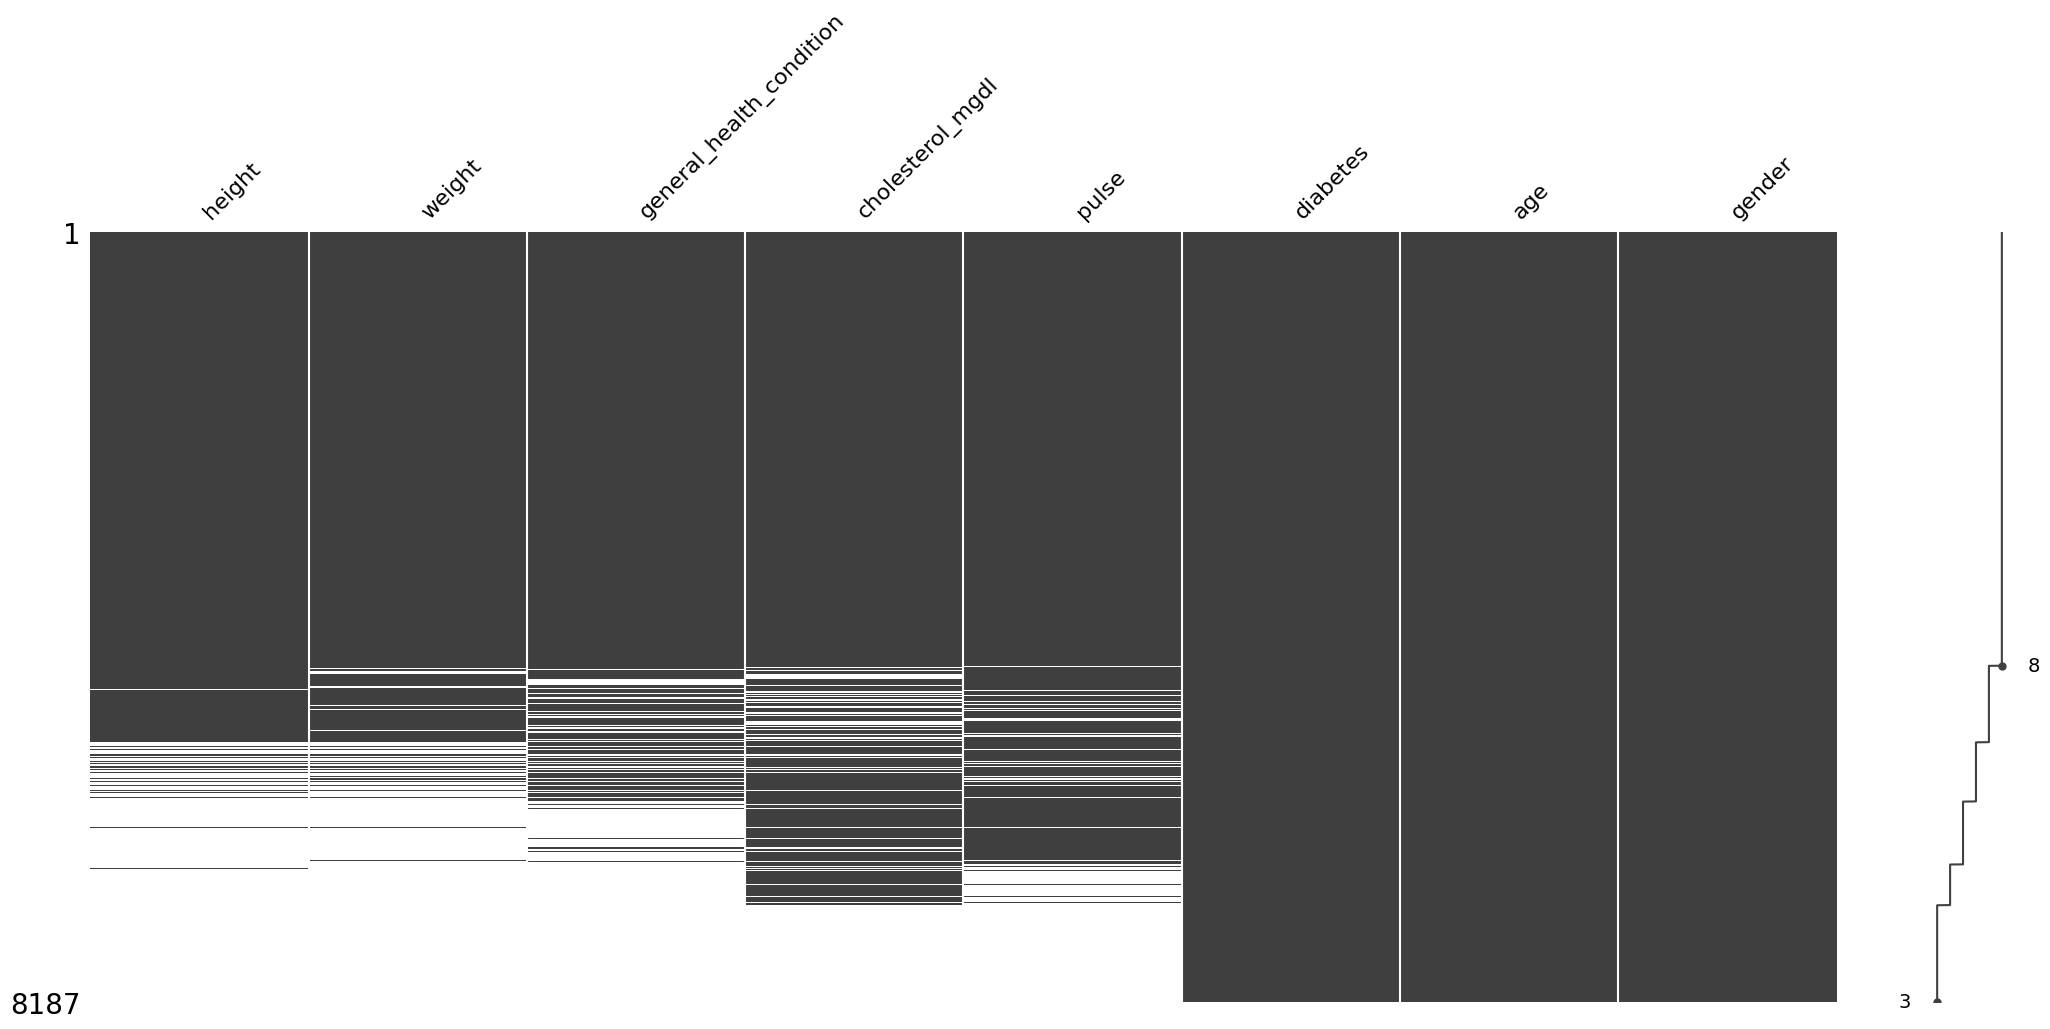

In [21]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix,sort='descending')
)

Aquí graficamos nuestro conjunto de datos por valores faltantes pero de forma descendente.

Vemos que hay 3 variables que no tienen valores faltantes y otras 5 que si tienen valores faltantes.

Veamos el comportamiento que tienen los valores faltantes en la parte inferior, donde hay una relación de valores faltantes en diversas variables.

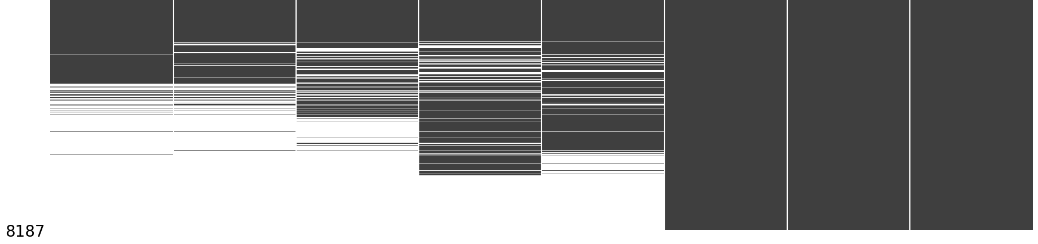

### ¿Cómo podemos visualizar la relación de  valores faltantes entre mis variables?

Usando un Upsetplot

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

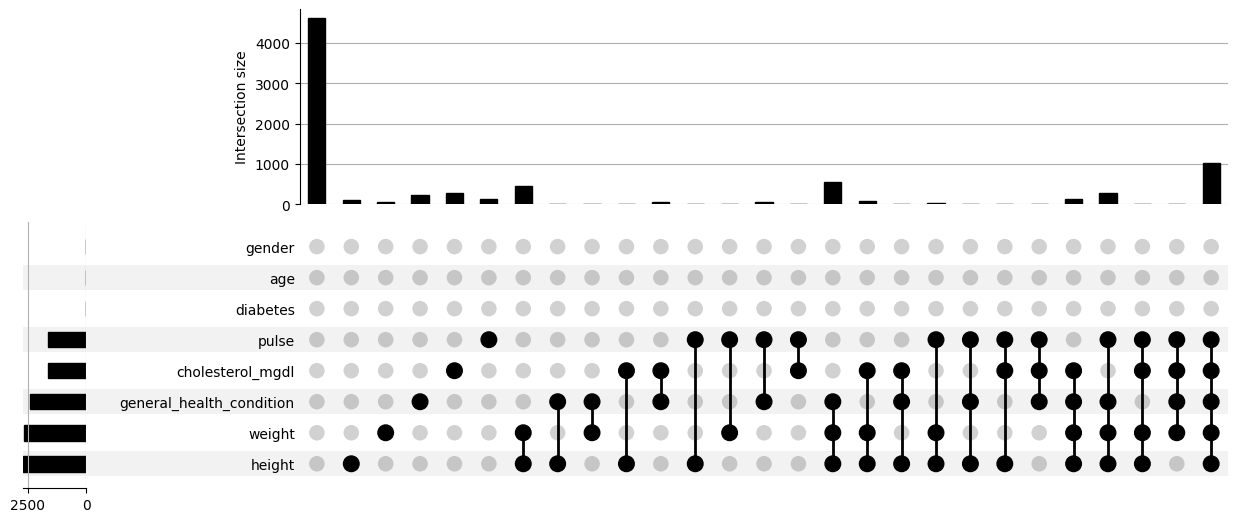

In [22]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)

En la primera columna vemos que no hay valores faltantes y corresponden a nuestra mayor cantidad del set de datos. El resto de valores faltantes esta distribuido en las demás categorías o columnas.

Debemos poner atención en la última columna, es la que posee cerca de 1000 observaciones de valores faltantes, ademas se puede observar como es la relación con todas las variables que en este caso son 5.

Nosotros podemos elegir: eliminar o imputar, pero vamos a decantarnos por la imputación, que es lo que aprenderemos.


### Eliminando para fines prácticos

In [23]:
nhanes_df.columns

Index(['height', 'weight', 'general_health_condition', 'cholesterol_mgdl',
       'pulse', 'diabetes', 'age', 'gender'],
      dtype='object')

<Axes: >

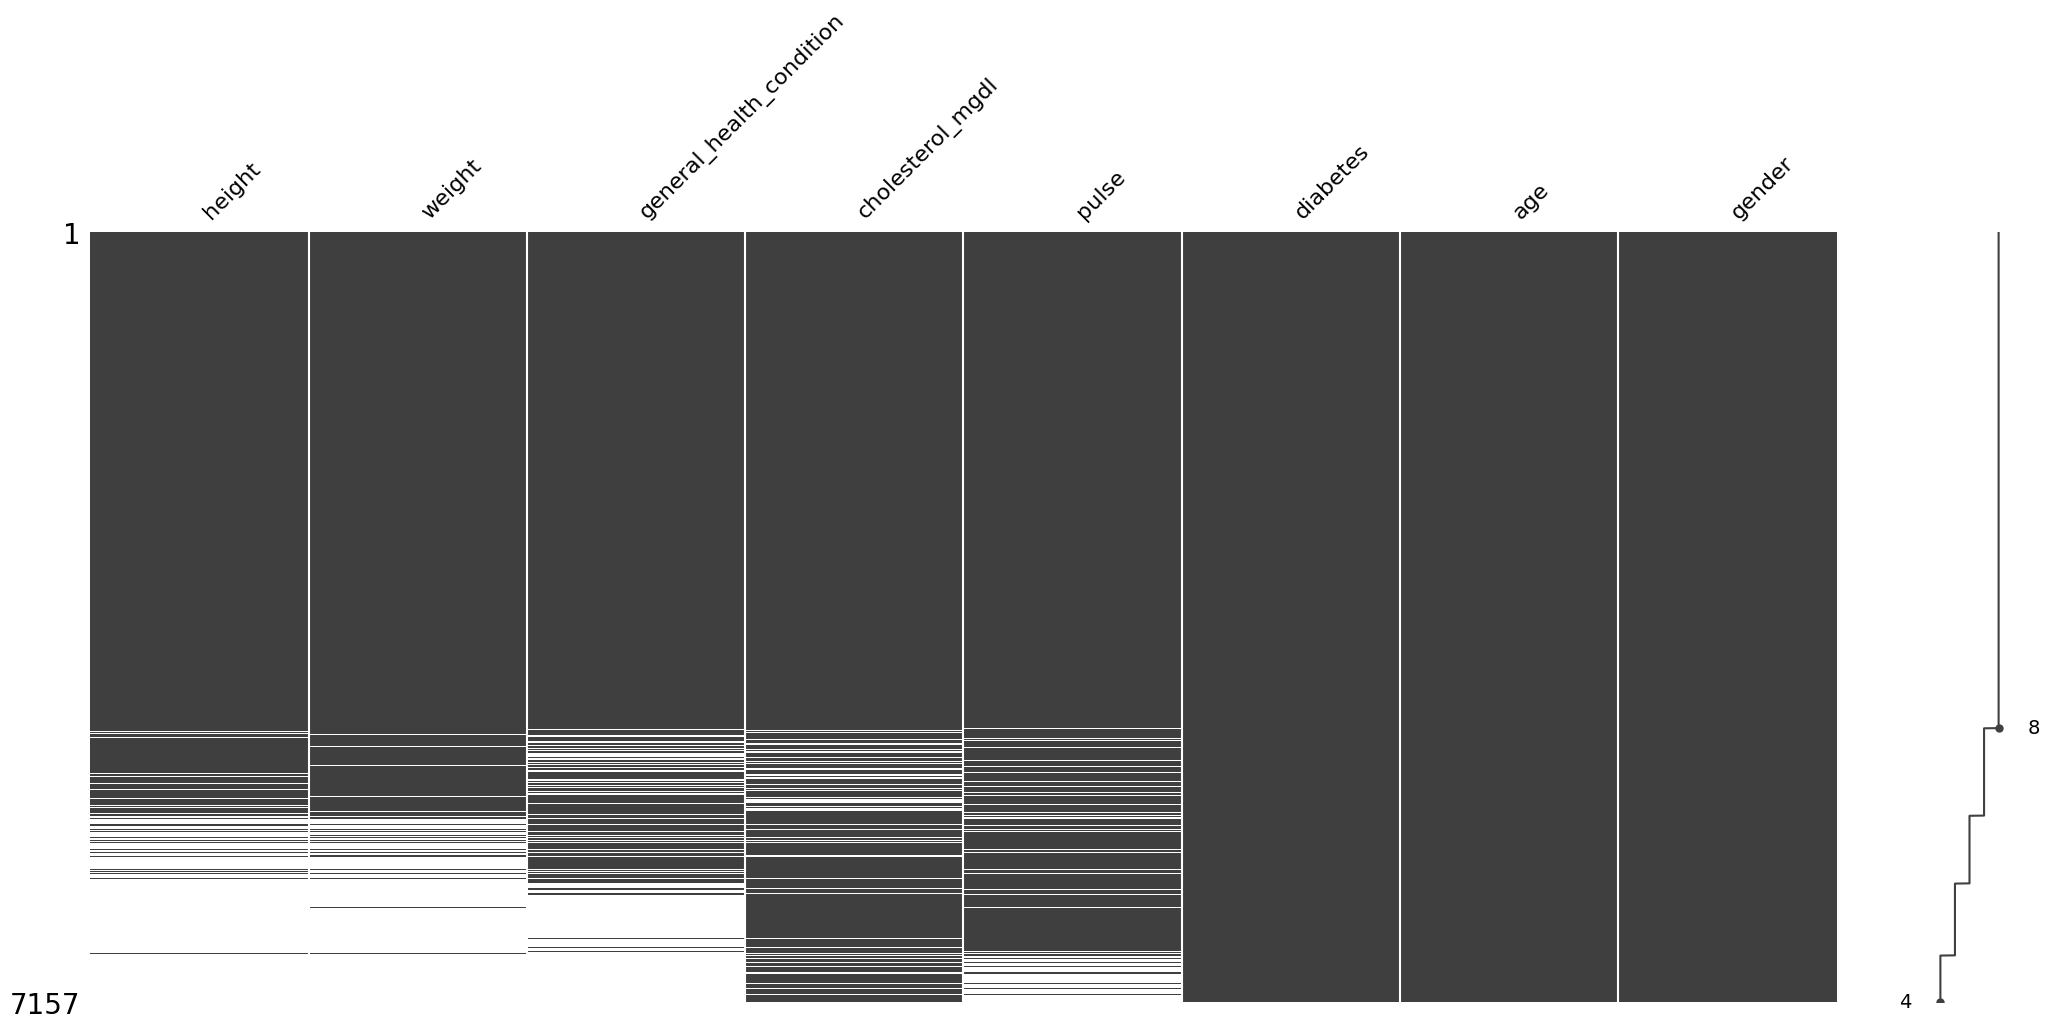

In [24]:
(
    nhanes_df
    .dropna(
        subset=['pulse','cholesterol_mgdl','general_health_condition','height','weight'],
        #Elimina faltantes solo si están en todas
        #las columnas
        how='all'
    )
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix,sort='descending')
)

Listo hemos conseguido eliminar la sección blanca de hasta abajo.

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

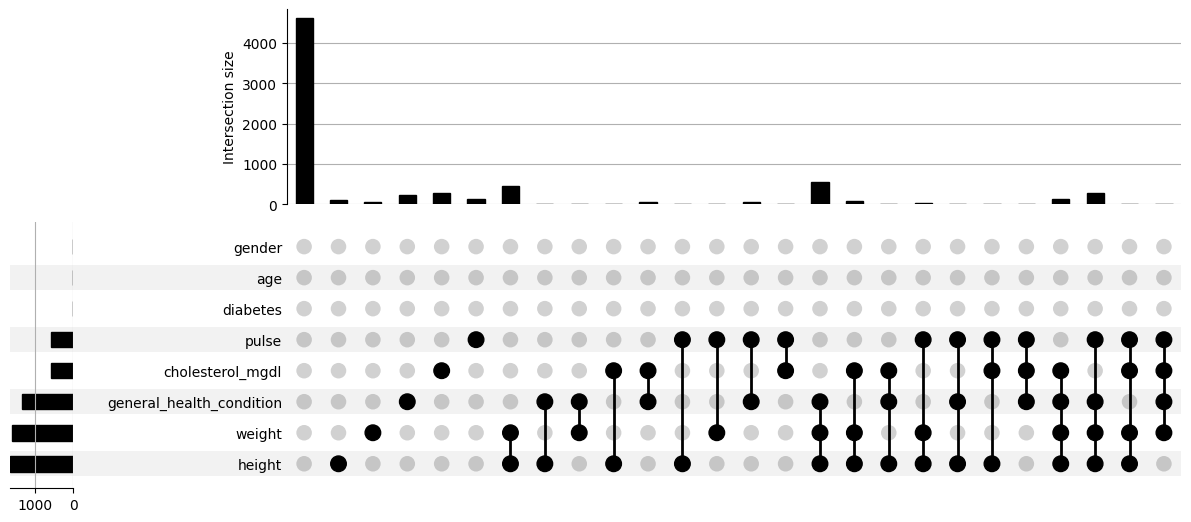

In [25]:
(
    nhanes_df
    .dropna(
        subset=['pulse','cholesterol_mgdl','general_health_condition','height','weight'],
        #Elimina faltantes solo si están en todas
        #las columnas
        how='all'
    )
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)

Hemos conseguido eliminarla, como hemos constatado.

Pero vamos a guardarla en un nuevo data frame. Así que solo quitaremos la parte de la visualización en nuestro código.

In [26]:
nhanes_dfwo100=(
    nhanes_df
    .dropna(
        subset=['pulse','cholesterol_mgdl','general_health_condition','height','weight'],
        #Elimina faltantes solo si están en todas
        #las columnas
        how='all'
    )
    .missing.sort_variables_by_missingness()
)
nhanes_dfwo100

,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


Hacemos la comparación de que tantas observaciones perdimos, recordemos que el numero de observaciones:

- nhanes_df tiene 8187
- nhanes_dfwo100 tiene 7157

### Ahora estamos listos para empezar a trabajar tomando como base nuestro set de datos con valores eliminados


## Implicaciones de los distintos tipos de valores faltantes <a id='tema4'></a>

[Ir a Indice](#indice)

Recordemos que tenemos 3 tipos de mecanismos de valores faltantes:
1. Missing Completely at Random
2. Missing at Random
3. Missing not at Random

#### MCAR
Definición: La localización de los valores faltantes en el conjunto de datos ocurre completamente al azar, estos no dependen de ningún otro dato.

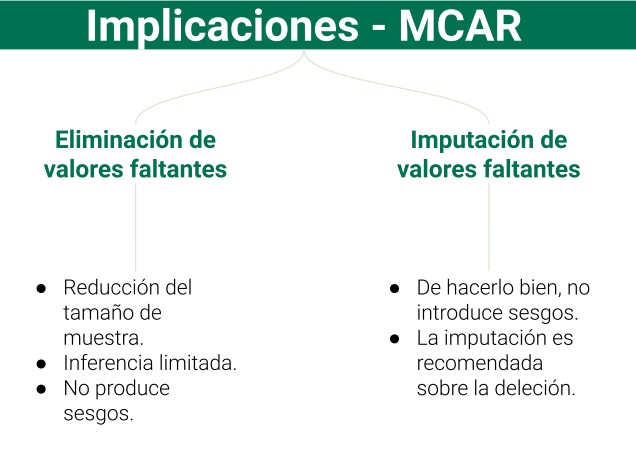

#### MAR
Definición: La localización de los valores faltantes en el conjunto de datos depende de otros valores observados.

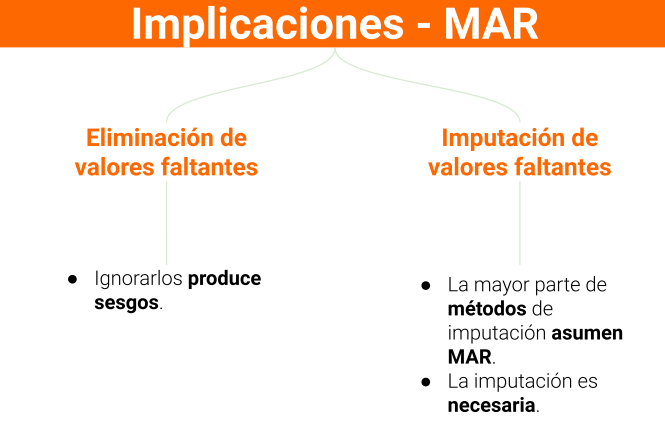

#### MNAR
Estos son los datos más complicados.

Definición: La localización de los valores faltantes en el conjunto de datos dependen de los valores faltantes en sí mismos.

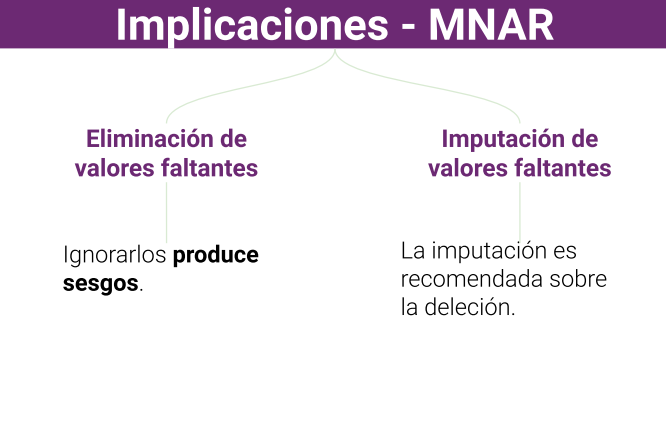

Para esto la imputación es buena pero no es tan recomendad.

**Para ello tenemos imputaciones multiples de variable que nos podrían empezar a ayudar un poco sobre este tipo de mecanismo, pero cuando veamos esto es mejor: MEJORAR EXPERIMENTOS O REALIZAR ANÁLISIS DE SENSIBILIDAD**

Es decir repetir los experimentos, explorar parámetros y ver que tanto cambian los análisis si cambiamos los valores de los datos, también establecer intervalos de confianza donde veamos que tan bueno es nuestros datos.

### Resumen

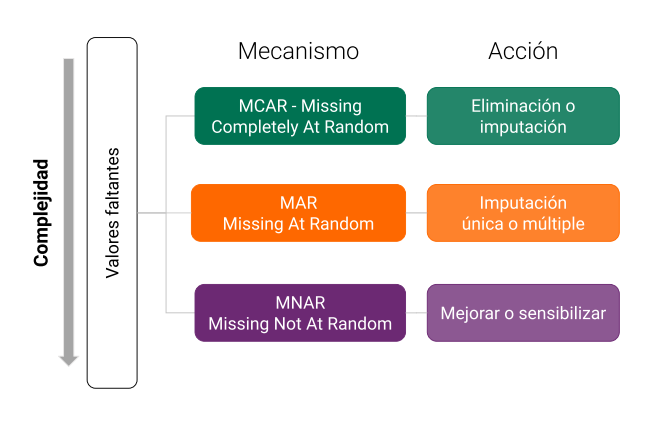

#### Evaluación del mecanismo de valores faltantes por prueba *t- test*

INFORMACIÓN     
- *two-sided:* Las **medias** de las distribuciones subyacentes a las muestras son **desiguales**.

- *less:* La **media** de la distribución subyacente a la **primera** muestra es **menor** que la media de la distribución subyacente a la **segunda** muestra.

- *greater:* La **media** de la distribución subyacente a la **primera** muestra es **mayor** que la media de la distribución subyacente a la **segunda** muestra.

#### Separando nuestros conjuntos de datos

In [27]:
(
    nhanes_dfwo100
    .select_columns('gender','weight')
    #transformando la columna de peso
    .transform_column(
        'weight',
        lambda x: x.isna(),
        elementwise = False
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,gender,weight
SEQN,,
93705.0,Female,False
93706.0,Male,False
93707.0,Male,True
93709.0,Female,False
93711.0,Male,False
...,...,...
102949.0,Male,False
102953.0,Male,False
102954.0,Female,False


In [28]:
female_weight,male_weight = (
    nhanes_dfwo100
    .select_columns('gender','weight')
    #transformando la columna de peso
    .transform_column(
        'weight',
        lambda x: x.isna(),
        elementwise = False
    )
    #Agrupar el conjunto de datos dado el genero
    .groupby('gender')
    #Accedemos al peso
    .weight     #nos regresa una serie agrupada
    .pipe( #vamos a separar nuestros grupos
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male'),
        ) #Esto nos regresara 2 Data Frames
    )
)
female_weight

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


SEQN
93705.0     False
93709.0     False
93714.0     False
93719.0      True
93721.0     False
            ...  
102941.0     True
102943.0    False
102948.0    False
102954.0    False
102955.0     True
Name: weight, Length: 3665, dtype: bool

Aquí podemos ver como está agrupado por genero para saber si tenemos valor en **weight** o no

#### Observando si la ausencia de valores afecta

Para ello vamos a usar el modulo **scipy**

In [29]:
scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative='two-sided'
)

TtestResult(statistic=np.float64(-0.3621032192538131), pvalue=np.float64(0.7172855918077239), df=np.float64(7155.0))

Lo que nos arroja es 0.71 y no podemos decir que hay una diferencia en los registros de las personas a los valores faltantes.


## Amplia tu conjunto de herramientas para explorar valores faltantes <a id='tema5'></a>

[Ir a Indice](#indice)

Vamos a enlistar lo que llevamos:
- Ya conocemos las implicaciones de los diferentes mecanismos de valore faltantes.
- Hemos construido diferentes visualizaciones para valores faltantes.
  - Así pudimos ver la presencia y proporción
  - Cómo se agrupan en filas y columnas
  - Observamos que nos faltaba en cada una de las observaciones
  - Creamos gráficas que nos permiten agrupar y relacionar variables.
  - Exploramos datasets, relacionando variables categóricas con variables numéricas

Así que esto solo es el inicio, ya que aprendimos a construir nuevas formas de visualizar nuestros datos y la falta de ellos.

### **Explorar variables categóricas en cuestión de la ausencia de otra variable**

In [36]:
(
    nhanes_dfwo100
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight_NA = lambda df:df.weight.isna().replace([True,False],["NA","notNA"])
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,weight,general_health_condition,gender,weight_NA
SEQN,,,,
93705.0,165.0,Good,Female,notNA
93706.0,145.0,Very good,Male,notNA
93707.0,NaN,Good,Male,NA
93709.0,200.0,NaN,Female,notNA
93711.0,142.0,Very good,Male,notNA
...,...,...,...,...
102949.0,180.0,Excellent,Male,notNA
102953.0,218.0,Fair or,Male,notNA
102954.0,150.0,Good,Female,notNA


Vemos como hemos representado los datos faltantes y extraemos solo 3 columnas, pero también podemos ver que en las demás columna hay valores faltantes.

**Qué necesitamos?**

Necesitamos cuantificar el número de apariciones de valores faltantes en las columnas.

In [43]:
(
    nhanes_df
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight = lambda df:df.weight.isna().replace([True,False],["NAN","VALUE"])
    )
    .groupby(
        ['gender','general_health_condition','weight'],
        #No queremos quitar valores faltantes
        dropna=False,
        #Queremos agruparlos y contarlos
        as_index = True
    )
    .size()
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


gender  general_health_condition  weight
Female  Excellent                 NAN         65
                                  VALUE      212
        Fair or                   NAN         42
                                  VALUE      549
        Good                      NAN        113
                                  VALUE     1102
        Poor?                     NAN          3
                                  VALUE       94
        Very good                 NAN        103
                                  VALUE      659
        NaN                       NAN       1002
                                  VALUE      234
Male    Excellent                 NAN         62
                                  VALUE      273
        Fair or                   NAN         31
                                  VALUE      508
        Good                      NAN        112
                                  VALUE     1056
        Poor?                     NAN          2
                            

Ya que tenemos todo contado, vamos a graficar, para poder visualizarlo.

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


(<Figure size 640x480 with 3 Axes>,
 {('Female', 'Excellent', 'NAN'): (np.float64(0.0),
   0.0,
   np.float64(0.11889049711706766),
   0.0652127851587943),
  ('Female', 'Excellent', 'VALUE'): (np.float64(0.12001640028634723),
   0.0,
   np.float64(0.38776592905874374),
   0.0652127851587943),
  ('Female', 'Fair or', 'NAN'): (np.float64(0.0),
   0.06849147368338447,
   np.float64(0.03600604043889015),
   0.13913630335323987),
  ('Female', 'Fair or', 'VALUE'): (np.float64(0.03713194360816974),
   0.06849147368338447,
   np.float64(0.47065038573692125),
   0.13913630335323987),
  ('Female', 'Good', 'NAN'): (np.float64(0.0),
   0.21090646556121448,
   np.float64(0.0471211326402195),
   0.2860416388734119),
  ('Female', 'Good', 'VALUE'): (np.float64(0.04824703580949908),
   0.21090646556121448,
   np.float64(0.4595352935355919),
   0.2860416388734119),
  ('Female', 'Poor?', 'NAN'): (np.float64(0.0),
   0.5002267929592165,
   np.float64(0.015669786376571487),
   0.02283624606643693),
  ('Fem

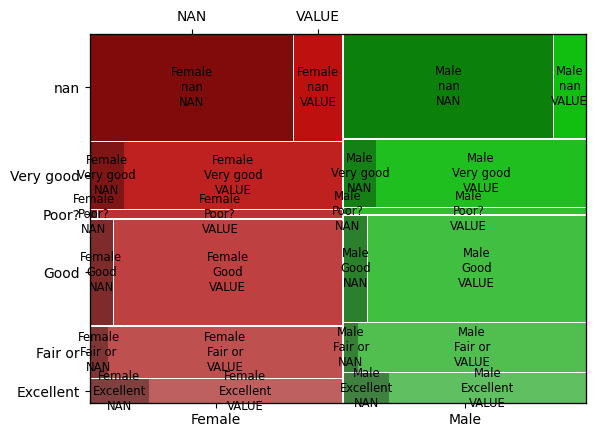

In [45]:
(
    nhanes_df
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight = lambda df:df.weight.isna().replace([True,False],["NAN","VALUE"])
    )
    .groupby(
        ['gender','general_health_condition','weight'],
        #No queremos quitar valores faltantes
        dropna=False,
        #Queremos agruparlos y contarlos
        as_index = True
    )
    .size()
    #Graficar
    .pipe(
        lambda df: mosaic(
            data = df
        )
    )
)

En este momento ya podemos visualizar las proporciones de nuestros datos.Es decir desde nuestras categorías de "general_health_condition" y su segmentación por "gender", para poder estimar adecuadamente la proporción.

Además podemos personalizar cada vez más este tipo de gráfica, para que sea mas legible. 

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


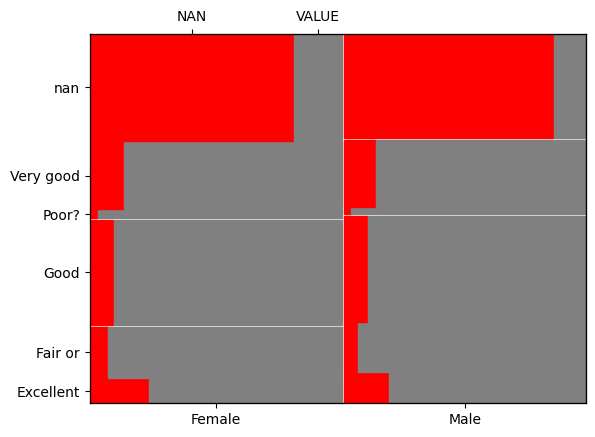

In [ ]:
(
    nhanes_df
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight = lambda df:df.weight.isna().replace([True,False],["NAN","VALUE"])
    )
    .groupby(
        ['gender','general_health_condition','weight'],
        #No queremos quitar valores faltantes
        dropna=False,
        #Queremos agruparlos y contarlos
        as_index = True
    )
    .size()
    #Graficar
    .pipe(
        lambda df: mosaic(
            data = df,
            #colorear
            properties= lambda key:{'color':'r' if 'NAN' in key else 'gray'},
            #cambiar orientación
            horizontal=True,
            #cambiar etiquetas
            axes_label=True,
            title='',
            labelizer=lambda key:''
        )
    )
);
# el punto y coma es para que el texto no se vea

Podemos personalizarlo aún mas, por ejemplo el tamaño de nuestra gráfica. Por medio de **matplotlib**



/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


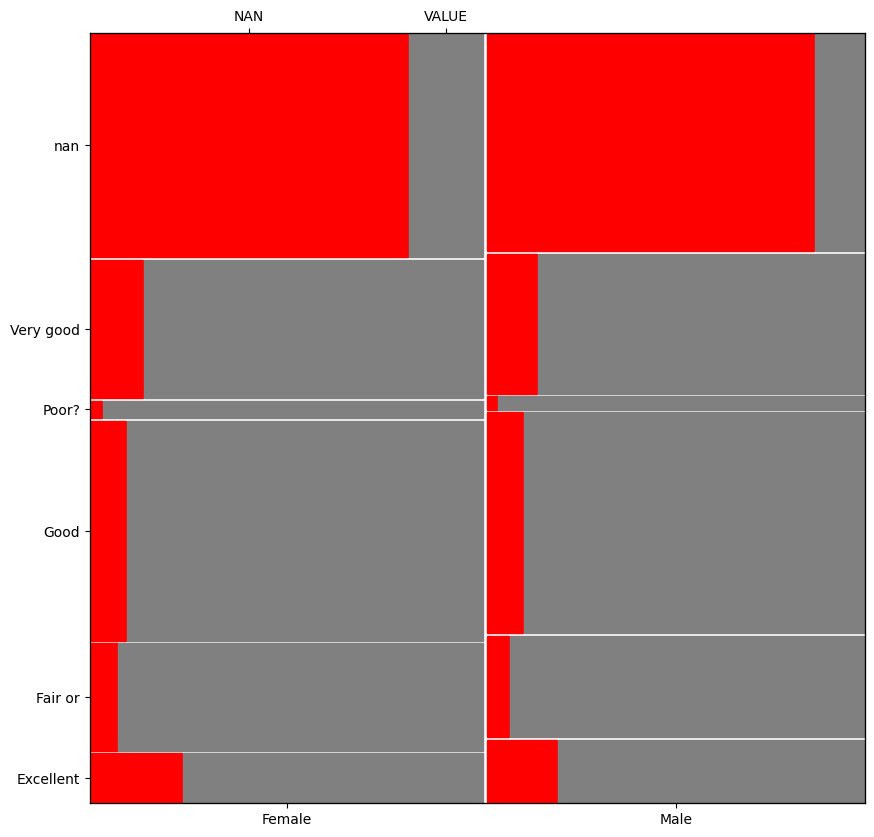

In [47]:
#añadi esto
fit,ax = plt.subplots(figsize=(10,10))
(
    nhanes_df
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight = lambda df:df.weight.isna().replace([True,False],["NAN","VALUE"])
    )
    .groupby(
        ['gender','general_health_condition','weight'],
        #No queremos quitar valores faltantes
        dropna=False,
        #Queremos agruparlos y contarlos
        as_index = True
    )
    .size()
    #Graficar
    .pipe(
        lambda df: mosaic(
            data = df,
            #colorear
            properties= lambda key:{'color':'r' if 'NAN' in key else 'gray'},
            #cambiar orientación
            horizontal=True,
            #cambiar etiquetas
            axes_label=True,
            title='',
            labelizer=lambda key:'',
            #añadi esto
            ax=ax
        )
    )
);
# el punto y coma es para que el texto no se vea

##### **Esta es una nueva forma de explorar variables categóricas, pero recuerda que cada visualización puede ser aplicada en multitud de situaciones**

Ahora trata de abstraer este concepto a una función llamada *missing_mosaic_plot(par1,par2,par3)*

BUSCA EL RESULTADO EN "panda_missing_extension"

## Tratamiento de variables categóricas para imputación: codificación ordinal <a id='tema6'></a>

[Ir a Indice](#indice)

Estamos muy cerca de comenzar el proceso de imputación de valores faltantes, pero nos vamos a dar cuenta que en las variables; tenemos de tipo categóricas. ¿qué pasa con este tipo de variables?
sucede que la mayor parte de las variables categóricas son cadenas de texto, realizar operaciones con este tipo **no es algo trivial**, por lo que surge la necesidad de **codificar o convertir** las cadenas de texto a números, de tal manera que los algoritmos puedan entenderlos y asociarlos, para que así podamos imputar los valores faltantes de una manera sencilla, así después convertir los números a su forma de texto.

**Comencemos**


#### Codificación ordinal 
Sucede lo siguiente, preguntemos a nuestros amigos

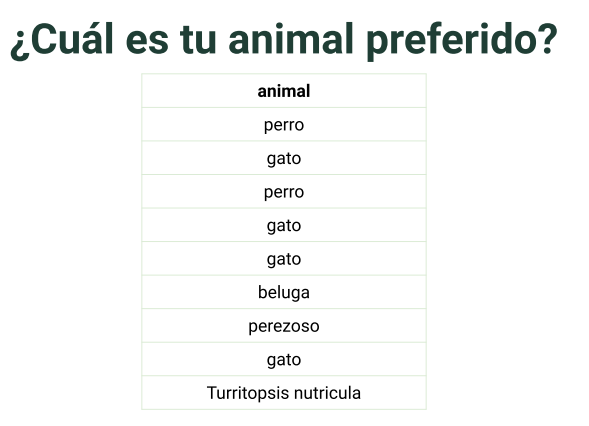

**Esto se traduce a convertir cada cadena de texto a un número entero, como en el ejemplo quedaría algo así:**

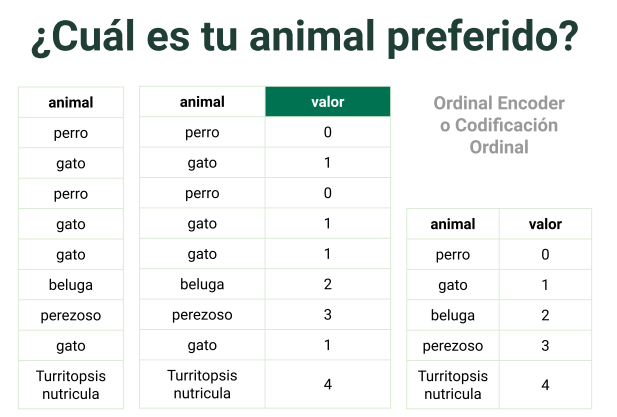

Una vez tenemos el proceso de codificación, podemos meter nuestros datos a un algoritmo para el proceso de imputación.

**Apliquemos en código**

#### **1. Siempre crea una copia de DataFrame**
Para asegurarnos que no estamos modificando nada de nuestros conjunto de datos original y así en algún momento tener un backup que nos ayude a entender que fue lo que hicimos.

In [48]:
#Deep para asegurarnos que tenga una dirección de 
#memoria distinta
nhanes_transform_df=nhanes_df.copy(deep=True)

**Realizaremos un ejemplo sencillo de codificación**

In [49]:
X = [["Male"],["Female"],["Female"]]
X

[['Male'], ['Female'], ['Female']]

Creando un encoder, que será el responsable de codificar la información.

In [ ]:
#Definimos un encoder
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"],["Female"],["Female"]]
X

[['Male'], ['Female'], ['Female']]

Ya estamos listos para codificar estos valores.

¿cómo lo hacemos?

In [51]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

Lo que hace `fit_transform()` es ajustar nuestros datos de acuerdo a sus valores. Así el parámetros que recibe es nuestro arreglo de datos o variable.

Observemos como nuestro arreglo quedó con 1's y 0's.

Lo que se traduce a:
- Male: 1
- Female: 0

Aquí estamos adivinando porque es un ejemplo muy pequeño, pero si tuviéramos distintas categorías, esto no sería lo más apropiado. Por fortuna estos **encoders** que nos provee *scikit_learn* tiene una función `categories_`

In [52]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

Aquí podemos intuir que el arreglo es:     
[0,1] donde 0 es 'Female' y 1 'Male'.

Pero imaginemos que queremos obtener la cadena de texto al ingresar un valor numérico; es decir la inversa de la transformación.

Para ello también tenemos la función `inverse_transform()` 

In [53]:
encoder.inverse_transform([[1],[1],[0],[1],[0]])

array([['Male'],
       ['Male'],
       ['Female'],
       ['Male'],
       ['Female']], dtype=object)

Así se hace una codificación ordinal.

Ahora apliquemos este de tipo de codificación ordinal a las variables categóricas en nuestro conjunto de datos.

In [54]:
#escogiendo variables categóricas
nhanes_df.select_dtypes(include=[object,'category'])

,general_health_condition,gender
SEQN,,
93703.0,NaN,Female
93704.0,NaN,Male
93705.0,Good,Female
93706.0,Very good,Male
93707.0,Good,Male
...,...,...
102951.0,NaN,Male
102953.0,Fair or,Male
102954.0,Good,Female


Pero solo queremos el nombre de las variables. Así que procedemos a realizar lo siguiente:

In [62]:
#escogiendo variables categóricas
categorical_columns = nhanes_df.select_dtypes(include=[object,'category']).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

Con esto ya tenemos guardadas las variables categóricas que vamos a utilizar.

Ahora vamos a usar una función de *scikit-learn* para componer instrucciones de transformación de nuestros datos.

In [67]:
sklearn.compose.make_column_transformer(
   # transformer                          variables a transformar
   (sklearn.preprocessing.OrdinalEncoder(),categorical_columns), 
   remainder='passthrough'
)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

Esta función lo que recibe es:
- una tupla que recibe 2 elementos:
  - primero: transformador que queremos hacer.
  - segundo: nombres de las columnas a transformar.
- remainder: nos ayuda a decidir que hacer con las demás variables; "passthrough" me dice que las conservar y no las modifica.

Con esto ya tenemos nuestro transformador creado, pero no lo hemos asignado a ninguna variable. Hagamoslo

In [65]:
categorical_transformer = sklearn.compose.make_column_transformer(
   # transformer                          variables a transformar
   (sklearn.preprocessing.OrdinalEncoder(),categorical_columns), 
   remainder='passthrough'
)

Guardarlo en un nuevo Data Frame

In [66]:
(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df)
    )
)

,0,1,2,3,4,5,6,7
0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
1,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
2,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
3,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
4,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
8182,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
8183,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
8184,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0
8185,4.0,0.0,NaN,NaN,150.0,74.0,0.0,14.0


Nos esta modificando nuestras columnas, así que ajustemos para que solo modifique los valores.

In [68]:
(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out()
    )
)

,ordinalencoder__general_health_condition,ordinalencoder__gender,remainder__height,remainder__weight,remainder__cholesterol_mgdl,remainder__pulse,remainder__diabetes,remainder__age
0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
1,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
2,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
3,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
4,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
8182,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
8183,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
8184,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0
8185,4.0,0.0,NaN,NaN,150.0,74.0,0.0,14.0


Vemos que las columnas que tienen un prefijo **ordinal** son a las que se les ha aplicado la codificación, **remainder** son aquellas que no se les ha aplicado nada. También podemos remover los prefijos. En caso de necesitar que se conserven los indices y trackear los que ya teníamos en nuestro data frame original.

In [69]:
(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=nhanes_df.index
    )
)

,ordinalencoder__general_health_condition,ordinalencoder__gender,remainder__height,remainder__weight,remainder__cholesterol_mgdl,remainder__pulse,remainder__diabetes,remainder__age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


Así tenemos una correspondencia entre los datos originales y los datos que han sido codificados.

Ahora vamos a modificar el nombre de las columnas con nuestra biblioteca **janitor**.

In [75]:
(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=nhanes_df.index
    )
    .rename_columns(
        function=lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function=lambda x: x.removeprefix('remainder__')
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,height,weight,cholesterol_mgdl,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


Listo, ya tendríamos un conjunto de datos que luce idéntico al conjunto de datos original, la única diferencia es que nuestros valores categóricos ahora está codificados como valores numéricos, ademas seguimos teniendo los valores faltantes, lo que se traduce en algo favorable para poder trabajarlos y saber que es lo que queremos imputar.

En este caso vemos que hay 2 variables categóricas, pero imaginemos que tenemos 10 o más, entonces ya nos podríamos haber ahorrado mucho trabajo.

**YA LOGRAMOS CODIFICAR VARIABLES CATEGÓRICAS, UN PROCESO NECESARIO PARA LA IMPUTACIÓN DE VALORES**.

Regresemos para ver como podemos aplicar este proceso aun Data Frame para poder usarlo posteriormente.

In [78]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=nhanes_df.index
    )
    .rename_columns(
        function=lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function=lambda x: x.removeprefix('remainder__')
    )
)
nhanes_transformed_df

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,height,weight,cholesterol_mgdl,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


## Tratamiento de variables categóricas para imputación: one-hot encoding <a id='tema7'></a>

[Ir a Indice](#indice)

## Métodos de imputación de valores faltantes <a id='tema8'></a>

[Ir a Indice](#indice)

## Imputación por media, mediana y moda <a id='tema9'></a>

[Ir a Indice](#indice)

## Imputación por llenado hacia atrás y hacia adelante <a id='tema10'></a>

[Ir a Indice](#indice)

## Imputación por interpolación <a id='tema11'></a>

[Ir a Indice](#indice)

## Imputación por KNN <a id='tema12'></a>

[Ir a Indice](#indice)

## Imputación por KNN en Python <a id='tema13'></a>

[Ir a Indice](#indice)

## Introducción a la imputación basada en modelos <a id='tema14'></a>

[Ir a Indice](#indice)

## Imputaciones Múltiples por Ecuaciones Encadenadas(MICE) <a id='tema15'></a>

[Ir a Indice](#indice)

## Transformación inversa de los datos <a id='tema16'></a>

[Ir a Indice](#indice)

## ¿Cómo continuar practicando? <a id='tema17'></a>

[Ir a Indice](#indice)